# Satellite Image Processing with Deep Learning
## Dr. Tristan Behrens

In this notebook we will:
- Solve the EuroSAT-10 classification problem,
- to that end use Convolutional Neural Networks,
- decrease overfitting with dropout,
- decrease overfitting even further with data augmentation, and
- solve the problem with transfer learning.

## Miscellaneous

- Subscribe to my YouTube channel: https://www.youtube.com/channel/UCcMEBxcDM034JyJ8J3cggRg
- Add me on LinkedIn: https://www.linkedin.com/in/dr-tristan-behrens-ai-guru-734967a2/


## Make sure that we have TensorFlow 2 enabled.

In [ ]:
%tensorflow_version 2.x

## Import all necessary modules  and check TensorFlow version.

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith("2."), "You have TensorFlow version {}, 2.X is required, please upgrade.".format(tf.__version__)

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

## Set some parameters and prepare for training.

In [ ]:
histories = {}
epochs = 100
batch_size = 1024

## Load and split EuroSAT-dataset.

We split the data into three subsets:
- Train: For training the Neural Network.
- Validate: To see how good the Neural Network is after each epoch.
- Test: To see how good the Neural Network is after training.

Link: [EuroSAT](https://github.com/phelber/eurosat).

In [ ]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    name="eurosat/rgb", 
    split=["train[:70%]", "train[70%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)
print(info)
print("Train:   ", len(list(dataset_train_original)))
print("Validate:", len(list(dataset_validate_original)))
print("Test:    ", len(list(dataset_test_original)))

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteTBEU19/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017

## Look at your data!

As always: Never trust the source of your data. Even if you created it. Do not worry, this is not paranoia. It is just a good way how to ensure the quality of your project. Always look at your data, because most of the times if there is something not so nice, the data is the cause.

In [ ]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea & lake"]

def label_to_string(label):
  return class_names[label]

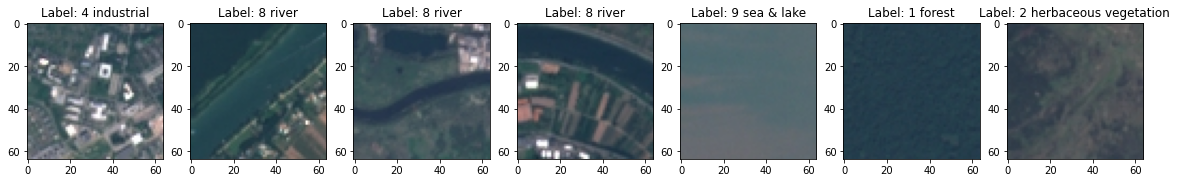

In [ ]:
index = 1
plt.figure(figsize=(20, 3))
for dataset_example in dataset_train_original.take(7):
    image, label = dataset_example

    plt.subplot(1, 7, index)
    plt.imshow(image.numpy())
    plt.title("Label: {} {}".format(label.numpy(), label_to_string(label.numpy())))
    index += 1
plt.show()
plt.close()

## Preparing the datasets with tf.data.

We will make sure that all images are normalized and that all labes are one-hot-encoded.

Link: [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

In [ ]:
def encode(image, label):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label_encoded = tf.one_hot(label, depth=10)
    return image_encoded, label_encoded

dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

## A second look at our data.

This is how the data looks like that the Neural Network will be trained on.

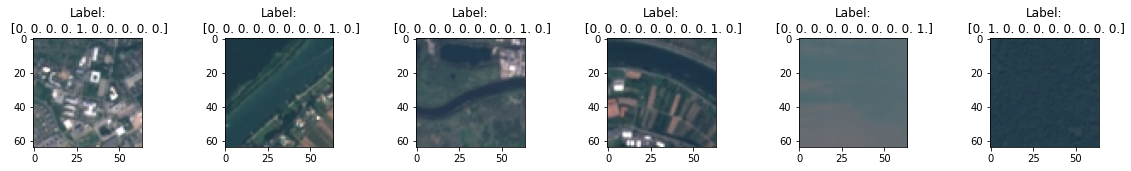

In [ ]:
index = 1
plt.figure(figsize=(20, 2))
for dataset_example in dataset_train.take(6):
    image, label = dataset_example

    plt.subplot(1, 6, index)
    plt.imshow(image.numpy())
    plt.title("Label:\n {}".format(label.numpy()))
    index += 1
plt.show()
plt.close()

## Create a Deep Neural Network to solve our classification problem - Convolutional Neural Network.


In [ ]:
model = models.Sequential()

# Convolutional block 1.
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional block 2.
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional block 3.
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))

# Latent space.
model.add(layers.Flatten())

# Classifier.
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       7

---

The architecture exhibits three structures:

1. The Convolutional blocks act as Feature Extractors.
2. The Flatten layer facilitates a Latent Space.
3. The Dense layers is the actual classifier.

## Attach optimizer, loss, and metrics.

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## How good is our ANN before training?

In [ ]:
loss, acc = model.evaluate(dataset_test.batch(32), verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

Loss: 2.304682731628418
Accuracy: 0.07666666805744171


## ANN training.

In [ ]:
history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Baseline"] = history

Epoch 1/100
19/19 [==============================] - 13s 703ms/step - loss: 2.0739 - accuracy: 0.2243 - val_loss: 1.8379 - val_accuracy: 0.2754
Epoch 2/100
19/19 [==============================] - 7s 368ms/step - loss: 1.6139 - accuracy: 0.3613 - val_loss: 1.4476 - val_accuracy: 0.3994
Epoch 3/100
19/19 [==============================] - 7s 364ms/step - loss: 1.3461 - accuracy: 0.4614 - val_loss: 1.2324 - val_accuracy: 0.5319
Epoch 4/100
19/19 [==============================] - 7s 363ms/step - loss: 1.1727 - accuracy: 0.5584 - val_loss: 1.1605 - val_accuracy: 0.5676
Epoch 5/100
19/19 [==============================] - 7s 362ms/step - loss: 1.0206 - accuracy: 0.6283 - val_loss: 0.9158 - val_accuracy: 0.6665
Epoch 6/100
19/19 [==============================] - 7s 359ms/step - loss: 1.0658 - accuracy: 0.6147 - val_loss: 1.0190 - val_accuracy: 0.6226
Epoch 7/100
19/19 [==============================] - 7s 358ms/step - loss: 0.8868 - accuracy: 0.6768 - val_loss: 0.9319 - val_accuracy: 0.668

## Inspect the history.



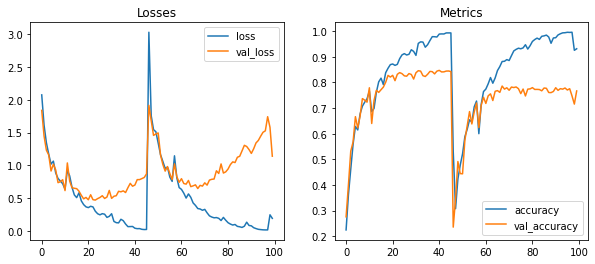

In [ ]:
def plot_history(history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.title("Losses")

  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.title("Metrics")

  plt.show()
  plt.close()

plot_history(history)

---

Although the problem is solved, we have some severe overfitting.

## How good is our ANN after training?


In [ ]:
loss, acc = model.evaluate(dataset_test.batch(32), verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

Loss: 1.0708227157592773
Accuracy: 0.7648147940635681


## Reducing overfitting by adding dropout.

Dropout enforces generalization by randomly dropping activations during training.

In [ ]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Dropout"] = history

plot_history(history)

## Reducing overfitting with Dropout and Data Augmentation.

Data Augmentation is artificially extending the dataset by changing the original data randomly.

In [ ]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    image_augmented = tf.image.random_brightness(image_augmented, 0.25)
    image_augmented = tf.image.random_hue(image_augmented, 0.2)
    return image_augmented, label

dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_train = dataset_train.map(lambda image, label: augment(image, label))
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

--- 

Let us have a look at how the augmented data looks like.

In [ ]:
plt.figure(figsize=(20, 2))
index = 1

dataset_example = list(dataset_train_original.take(1))[0]
image, label = dataset_example
plt.subplot(1, 6, index)
plt.imshow(image.numpy())
plt.title("Original")
index += 1

for _ in range(6):
    dataset_example = list(dataset_train.take(1))[0]
    image, label = dataset_example
    plt.subplot(1, 7, index)
    plt.imshow(image.numpy())
    plt.title("Augmented")
    index += 1

plt.show()
plt.close()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)

histories["Dropout-Augmentation"] = history

plot_history(history)

## Transfer Learning.

In [ ]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache()
dataset_train = dataset_train.map(lambda image, label: augment(image, label))
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: encode(image, label)).cache()

In [ ]:
from tensorflow.keras import applications
 
pretrained_model = applications.VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(64, 64, 3)
)
 
#for layer in pretrained_model.layers[:-5]:
#  layer.trainable = False
 
pretrained_model.summary()
 
pretrained_model.trainable = False
 
model = models.Sequential()
 
model.add(pretrained_model)
 
model.add(layers.Flatten())
 
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))
 
model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
 
history = model.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size)
)
 
histories["TransferLearning-Dropout-Augmentation"] = history
 
plot_history(history)

## Compare results.

In [ ]:
plt.figure(figsize=(10, 4))
  
plt.subplot(1, 2, 1)
for title, history in histories.items():
  plt.plot(history.history["val_loss"], label=title)
plt.legend()
plt.title("Validation Loss")
 
plt.subplot(1, 2, 2)
for title, history in histories.items():
  plt.plot(history.history["val_accuracy"], label=title)
plt.legend()
plt.title("Validation Accuracy")
 
plt.show()
plt.close()

# Summary.

For solving image processing problems, Convolutional Neural Networks are state of the art. There are several architecures available. We focused on interleaving Convolutional layers with Pooling layers.

As with all other use cases, overfitting can be a problem. We looked at Dropout and Data Augmentation for compensating overfitting.